In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import inf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression, RFECV, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [82]:
accuracies = dict()

df = pd.read_csv("heart.csv")

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [75]:
y = df["target"]
X = df.drop(columns = "target")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 54)

In [76]:
scaler = StandardScaler()  

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.transform(X)

## Реализация логистической регрессии

In [112]:
import warnings
import warnings
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder


class MyLogReg:
    def __init__(self, learning_rate=0.01, epochs=250, l2=0.01, random_seed=59):
        self.__weights = []
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_seed = random_seed
        self.l2 = l2

    def getWeights(self):
        return self.__weights

    def __sigmoid(self, z):
        warnings.filterwarnings('ignore')
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        
        samples, _ = np.shape(X)
        
        features = np.c_[np.ones(samples), X]
        y_encode = OneHotEncoder(sparse=False).fit_transform(y.values.reshape(-1,1))
        np.random.seed(self.random_seed)
        weights = np.random.random_sample((features.shape[1], y_encode.shape[1]))
        

#         for epoch in range(self.epochs):
#             z = X_full @ weights
#             h = self.__sigmoid(z)
#             gradient = (X_full.T @ (h - y)) / y.size
#             weights -= self.learning_rate * gradient
            
        for epoch in range(self.epochs):
            z = features @ weights
            h = softmax(-z, axis=1)
            error = y_encode - h
            gradient = 1 / samples * (features.T @ error) + 2 * self.l2 * weights
            weights -= self.learning_rate * gradient

        self.__weights = weights
        return self
    
    def score(self, X, y):
        return (self.predict(X) == y).mean()
    
    # function name needed by GridSearch 
    def predict_proba(self, X):
        features=np.c_[np.ones(X.shape[0]), X]
        return np.argmax(softmax(-features @ self.__weights, axis=1) ,axis=1)

    def predict(self, X):
        return self.predict_proba(X).astype(np.float64)

    def get_params(self, deep=False):
        return {
            "learning_rate": self.learning_rate,
            "epochs": self.epochs,
            "random_seed": self.random_seed,
            "l2": self.l2,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [115]:
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01], 
    'epochs':        [2000, 20000, 200000], 
    'l2':            [0.1, .001, .0001]
}

gs = GridSearchCV(MyLogReg(), return_train_score=True, error_score='raise',
                  param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

%time gs.fit(X_train_scaled, y_train)

print('='*20)
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

# best params: {'epochs': 20000, 'l2': 0.0001, 'learning_rate': 0.01}
# best score: 0.8476699770817417

CPU times: user 2.21 s, sys: 158 ms, total: 2.37 s
Wall time: 2min 3s
best params: {'epochs': 20000, 'l2': 0.001, 'learning_rate': 0.01}
best score: 0.8418527264920567


In [116]:
model_lr = MyLogReg(**gs.best_params_)
model_lr.fit(X_train_scaled, y_train)

In [117]:
acc = model_lr.score(X_test_scaled, y_test)
accuracies['MyLogReg'] = acc
acc

0.8508771929824561

## Реализация KNN

In [79]:
# Euclidean distance
def default_distance(point, data):
    return np.sqrt(np.sum((point - data) ** 2, axis=1))

class MyKNN:
    def __init__(self, k_neighbors=5, dist_func=None):
        self.k_neighbors = k_neighbors
        self.dist_func = default_distance if dist_func is None else dist_func

    def __most_common(self, lst):
        return max(lst, key=lst.count)

    

    def score(self, X, y):
        return (self.predict(X) == y).mean()

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.k_neighbors = min(self.k_neighbors, np.shape(X)[0])

        return self

    def predict_proba(self, X):
        return self.predict(X).astype(np.float64)

    def predict(self, X):
        neighbors = []
        for point in X:
            distances = self.dist_func(point, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k_neighbors])

        return np.array(list(map(self.__most_common, neighbors)))

    def get_params(self, deep=False):
        return {
            "k_neighbors": self.k_neighbors,
            "dist_func": self.dist_func,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [90]:
param_grid = {'k_neighbors': np.arange(1, 20, 1)}

my_knn = MyKNN()

gs = GridSearchCV(my_knn, return_train_score=True, error_score='raise',
                  param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

%time gs.fit(X_train_scaled, y_train)
my_knn.set_params(**gs.best_params_)
my_knn.fit(X_train_scaled, y_train)
acc = my_knn.score(X_test_scaled, y_test)
accuracies['MyKNN'] = acc

print('='*20)
print("best params: ", gs.best_params_)
print('best score:', gs.best_score_)
print('test score:', acc)
print('='*20)

# best params: {'epochs': 500000, 'learning_rate': 0.0001}
# best score: 0.853658536585366

CPU times: user 258 ms, sys: 9.72 ms, total: 268 ms
Wall time: 1.78 s
best params:  {'k_neighbors': 1}
best score: 0.9663267496779735
test score: 0.9912280701754386


### Гиперпараметры для библиотечных методов

In [85]:
# logreg

from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

log_reg = LogisticRegression()

gs = GridSearchCV(log_reg, return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(X_train_scaled, y_train)
log_reg.set_params(**gs.best_params_)
log_reg.fit(X_train_scaled, y_train)

acc = log_reg.score(X_test_scaled, y_test)
accuracies['LogReg'] = acc

print('='*20)
print("best params: ", gs.best_params_)
print('best score:', gs.best_score_)
print('test score:', acc)
print('='*20)

best params:  {'C': 0.20001000000000002}
best score: 0.8447509660798627
test score: 0.847953216374269


In [86]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 10, 1)
weights = ['uniform', 'distance']

knn = KNeighborsClassifier()

gs = GridSearchCV(knn, cv=5,
              scoring=scoring, return_train_score=True,
              param_grid=dict(n_neighbors=n_neighbors, weights=weights), refit='Accuracy')

gs.fit(X_train_scaled, y_train)
knn.set_params(**gs.best_params_)
knn.fit(X_train_scaled, y_train)

acc = knn.score(X_test_scaled, y_test)
accuracies['KNN'] = acc

print('='*20)
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('test score:', acc)
print('='*20)

best params: {'n_neighbors': 8, 'weights': 'distance'}
best score: 0.9736367539716617
test score: 0.9912280701754386


In [87]:
# naive bayes

from sklearn.naive_bayes import GaussianNB

var_smoothing = np.logspace(0, -9, num=100)

nb = GaussianNB()

gs = GridSearchCV(nb, cv=5, return_train_score=True,
              param_grid=dict(var_smoothing=var_smoothing), scoring=scoring, refit='Accuracy')

gs.fit(X_train_scaled, y_train)
nb.set_params(**gs.best_params_)
nb.fit(X_train_scaled, y_train)

acc = nb.score(X_test_scaled, y_test)
accuracies['Naive Bayes'] = acc

print('='*20)
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('test score:', acc)
print('='*20)

best params: {'var_smoothing': 0.657933224657568}
best score: 0.8242915414340919
test score: 0.827485380116959


In [88]:
# decision tree

from sklearn.tree import DecisionTreeClassifier

criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = np.arange(2, 20, 2)
min_samples_split = np.arange(2, 10, 2)
min_samples_leaf = np.arange(1, 8, 2)
max_features = np.arange(2, 8, 2)

decision_tree = DecisionTreeClassifier(random_state=17)
gs = GridSearchCV(decision_tree, cv=5, return_train_score=True,
        param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                        max_features=max_features), scoring=scoring, refit='Accuracy', n_jobs=-1)
%time gs.fit(X_train_scaled, y_train)

decision_tree.set_params(**gs.best_params_)
decision_tree.fit(X_train_scaled, y_train)

acc = knn.score(X_test_scaled, y_test)
accuracies['DecisionTree'] = acc

print('='*20)
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('test score:', acc)
print('='*20)

CPU times: user 3.36 s, sys: 194 ms, total: 3.56 s
Wall time: 7.74 s
best params: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
best score: 0.9751180764276514
test score: 0.9912280701754386


In [93]:
# SVM

from sklearn.svm import SVC

C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

svm = SVC(random_state=0)
gs = GridSearchCV(svm, cv=5, return_train_score=True,
        param_grid=dict(kernel=kernel,C=C, gamma=gamma), n_jobs=-1)
%time gs.fit(X_train_scaled, y_train)

svm.set_params(**gs.best_params_)
svm.fit(X_train_scaled, y_train)

acc = svm.score(X_test_scaled, y_test)
accuracies['SVM'] = acc

print('='*20)
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('test score:', acc)
print('='*20)

CPU times: user 218 ms, sys: 12.4 ms, total: 230 ms
Wall time: 626 ms
best params: {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
best score: 0.9531665951051952
test score: 0.9912280701754386


## Сравнение моделей

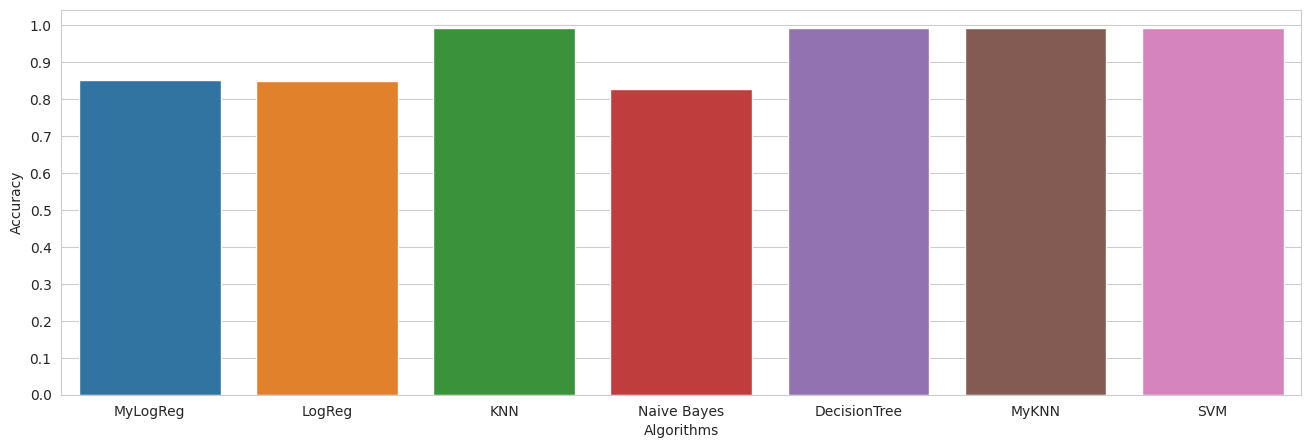

In [94]:
# colors = ["purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

## Confusion Matrix

In [95]:
y_head_lr = log_reg.predict(X_test_scaled)
y_head_knn = knn.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)
y_head_nb = nb.predict(X_test_scaled)
y_head_decision_tree = decision_tree.predict(X_test_scaled)
y_head_mylr = my_log_reg.predict(X_test_scaled)
y_head_myknn = my_knn.predict(X_test_scaled)

In [96]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_decision_tree = confusion_matrix(y_test, y_head_decision_tree)
cm_mylr = confusion_matrix(y_test, y_head_mylr)
cm_myknn = confusion_matrix(y_test, y_head_myknn)

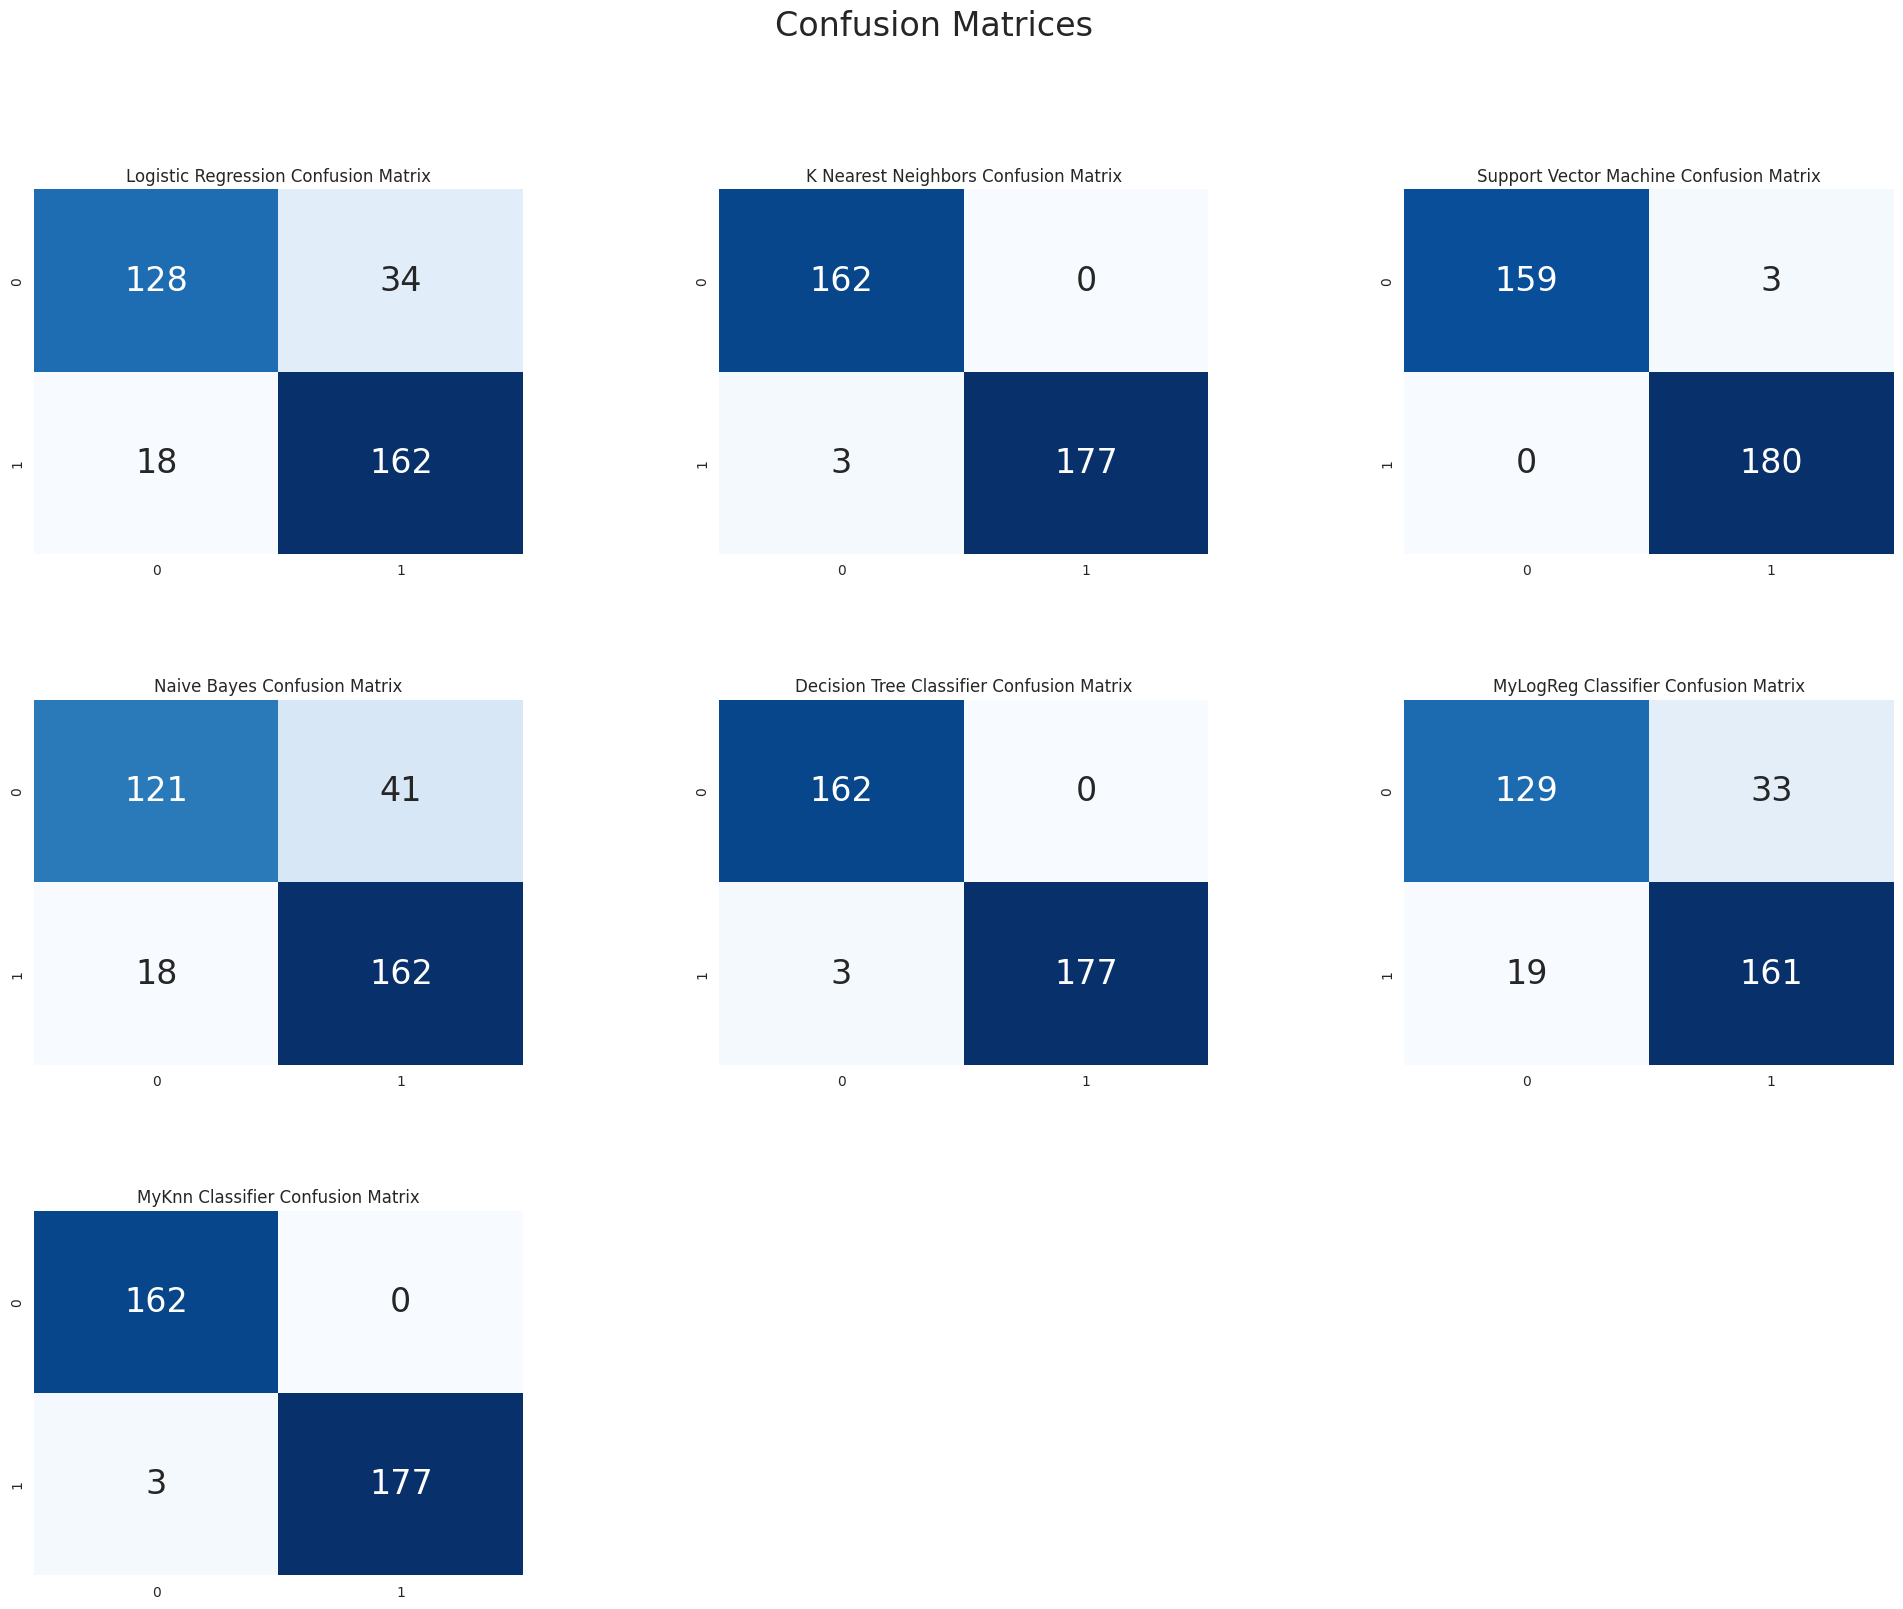

In [102]:
plt.figure(figsize=(24, 18))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_decision_tree,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,6)
plt.title("MyLogReg Classifier Confusion Matrix")
sns.heatmap(cm_mylr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,3,7)
plt.title("MyKnn Classifier Confusion Matrix")
sns.heatmap(cm_myknn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()